In [69]:
# Introduction to the Analysis
# In this project, we are working with the Seattle Airbnb dataset to predict 
# the price of Airbnb listings based on several factors like reviews, availability,
# and property type. The dataset contains details such as reviews, price, location, 
# and property characteristics, which will be used to build a machine learning model.


#In this analysis, we aim to help Airbnb hosts understand the key factors that influence the nightly prices of listings. 
#By understanding these factors, hosts can optimize their pricing strategies to maximize occupancy and revenue. 
#For example, knowing that properties with amenities like pools or hot tubs in certain neighborhoods tend to have higher prices, hosts can adjust their pricing strategies for peak seasons.


### Business Questions:
#1. **How do amenities affect the nightly price of Airbnb listings?**
#This is a crucial question because it helps hosts identify which amenities add the most value. For instance, a pool or hot tub may justify a higher price per night, leading to increased profits.
#2. **What neighborhood factors influence pricing the most?**
#Neighborhoods with high demand or unique attractions can result in higher nightly rates. By understanding these patterns, hosts can price their listings competitively in relation to others in the same area.
#3. **What seasonal trends affect Airbnb pricing?**
#Seasonal demand plays a major role in pricing decisions. Understanding these trends enables hosts to dynamically adjust prices for high-demand periods and take advantage of peak seasons.


# The following steps will be performed:
# 1. Handle missing values in the dataset.
# 2. Perform Exploratory Data Analysis (EDA) to understand key patterns.
# 3. Preprocess and clean the data for modeling.
# 4. Build a regression model to predict the price of listings.
# 5. Evaluate the model's performance based on Mean Squared Error (MSE).

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [73]:
# Step 1: Load the dataset and inspect it
# -----------------------------
# Load the listings dataset
listings = pd.read_csv('listings.csv')

# Display the first few rows of the dataset to get an overview
print("First few rows of the dataset:")
print(listings.head())

# Check for missing values in the dataset
print("\nMissing values per column:")
print(listings.isnull().sum())

First few rows of the dataset:
        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A 

In [74]:
# Step 2: Handle Missing Values
# -----------------------------
def handle_missing_values(df):
    """
    Handles missing values in the dataset.
    Fills numerical columns with the median and categorical with the mode.
    """
    # Handle numerical columns (fill with median)
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        df[column] = df[column].fillna(df[column].median())
    
    # Handle categorical columns (fill with mode)
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].fillna(df[column].mode()[0])

# Apply the function to handle missing values
handle_missing_values(listings)

# Verify if there are any remaining missing values
print("\nRemaining missing values after handling:")
print(listings.isnull().sum())


Remaining missing values after handling:
id                                  0
listing_url                         0
scrape_id                           0
last_scraped                        0
name                                0
                                   ..
cancellation_policy                 0
require_guest_profile_picture       0
require_guest_phone_verification    0
calculated_host_listings_count      0
reviews_per_month                   0
Length: 92, dtype: int64



Cleaned price column (first few entries):
0     85.0
1    150.0
2    975.0
3    100.0
4    450.0
Name: price, dtype: float64


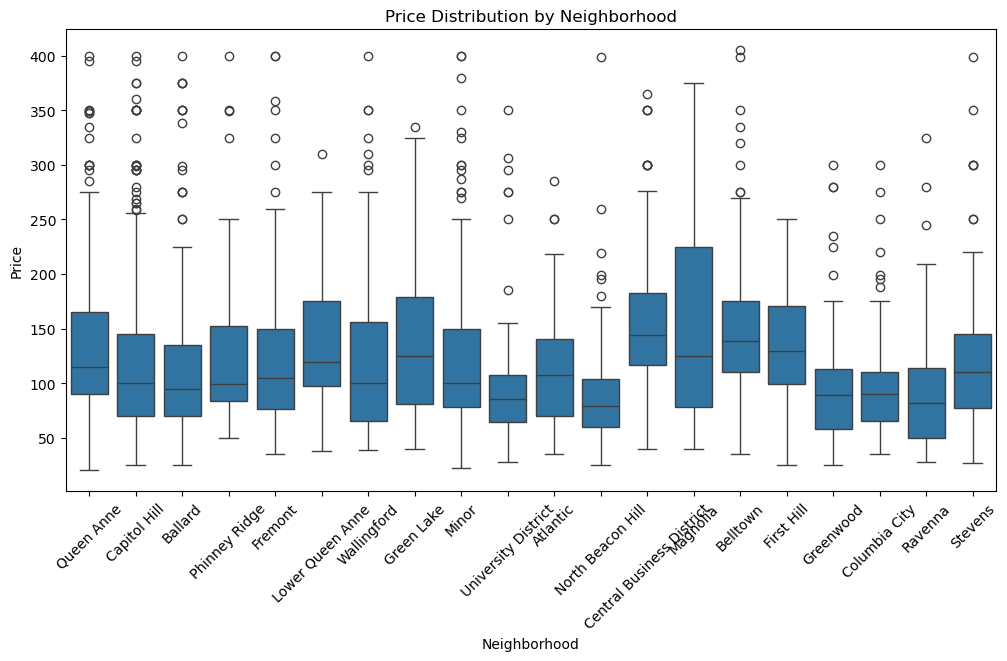

In [75]:
# Step 3: Clean and preprocess columns
# -----------------------------
# Clean the 'price' column by removing '$' and ',' and converting to float
listings['price'] = listings['price'].replace({'\\$': '', ',': ''}, regex=True)

# Convert to numeric, coercing any invalid values to NaN (which can later be handled)
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

# If there are missing values in 'price', fill them with the median
listings['price'] = listings['price'].fillna(listings['price'].median())

# Verify the cleaned 'price' column
print(f"\nCleaned price column (first few entries):\n{listings['price'].head()}")

# Step 1: Aggregate by Neighborhood and get the average price
neighborhood_price = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

# Step 2: Filter out neighborhoods with a low number of listings
# For example, consider only neighborhoods with at least 50 listings
neighborhood_counts = listings['neighbourhood'].value_counts()
valid_neighborhoods = neighborhood_counts[neighborhood_counts >= 50].index
filtered_listings = listings[listings['neighbourhood'].isin(valid_neighborhoods)]

# Step 3: Remove extreme outliers from the price column (optional but recommended for better visuals)
# Here we remove values that are above 3 standard deviations
price_mean = filtered_listings['price'].mean()
price_std = filtered_listings['price'].std()
filtered_listings = filtered_listings[filtered_listings['price'] < (price_mean + 3 * price_std)]

# Step 4: Create the boxplot for price distribution by neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood', y='price', data=filtered_listings)
plt.title('Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate neighborhood names for better readability
plt.show()


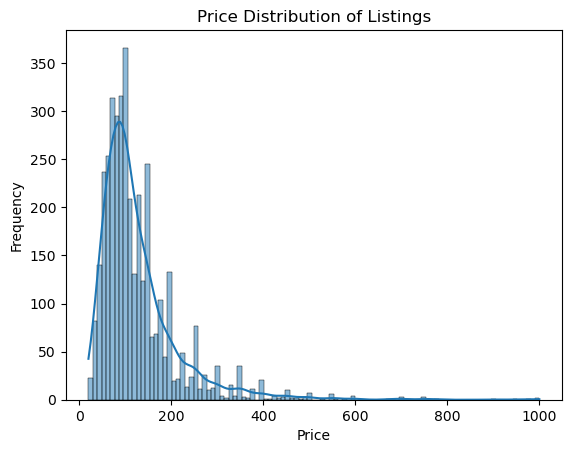

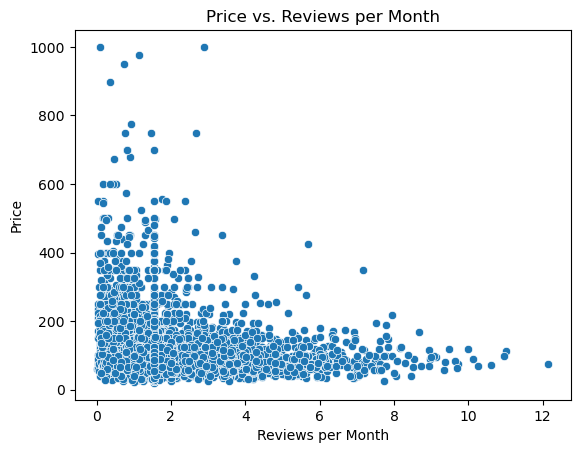

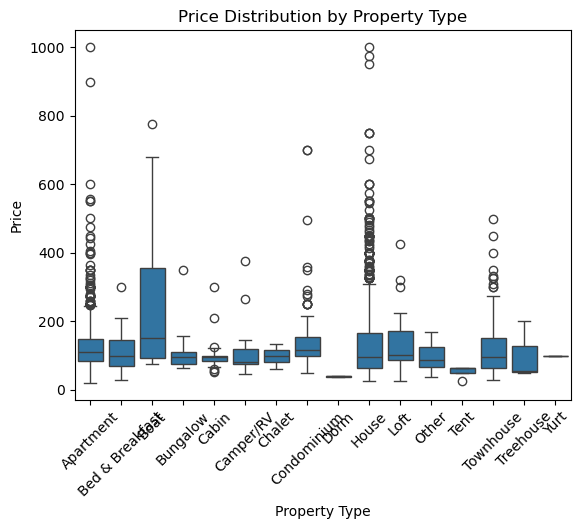

In [76]:
# Step 4: Exploratory Data Analysis (EDA)
# -----------------------------
# Visualize the distribution of 'price' column
sns.histplot(listings['price'], kde=True)
plt.title('Price Distribution of Listings')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between 'reviews_per_month' and 'price'
sns.scatterplot(x='reviews_per_month', y='price', data=listings)
plt.title('Price vs. Reviews per Month')
plt.xlabel('Reviews per Month')
plt.ylabel('Price')
plt.show()

# Visualize the price distribution by property type
# Ensure 'property_type' is a valid categorical variable
listings['property_type'] = listings['property_type'].astype('category')

# Remove rows with missing 'property_type'
listings = listings[listings['property_type'].notna()]

# Create the boxplot for price by property type
sns.boxplot(x='property_type', y='price', data=listings)
plt.title('Price Distribution by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

In [79]:
# Step 5: Feature Selection and Preprocessing
# -----------------------------
# Select relevant features for the model
features = ['reviews_per_month', 'availability_365', 'beds']
target = 'price'

# Drop rows with missing values in selected features
df_model = listings.dropna(subset=features + [target])

# X and y variables
X = df_model[features]
y = df_model[target]

In [80]:
# Step 6: Model Training and Evaluation
# -----------------------------
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'\nMean Squared Error: {mse}')



Mean Squared Error: 5315.172490236058


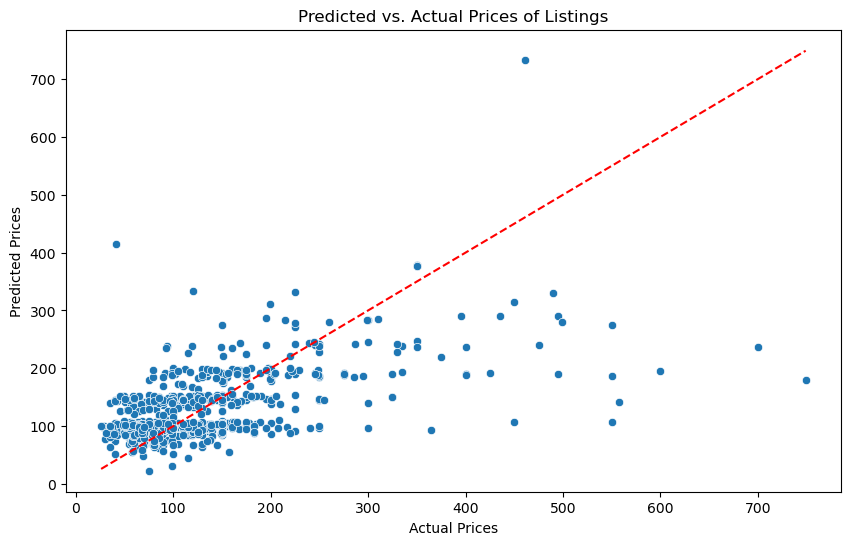

In [81]:
# Step 7: Plot Predicted vs. Actual Prices
# -----------------------------
# Create a DataFrame with the actual and predicted prices
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df)
plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         [comparison_df['Actual'].min(), comparison_df['Actual'].max()], color='red', linestyle='--')
plt.title('Predicted vs. Actual Prices of Listings')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()
